In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import math

import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.decomposition import PCA
from sklearn.preprocessing import *
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split

import tensorflow as tf
import tensorflow.keras as keras
from keras import callbacks
from keras import ops
from keras import layers
from keras import optimizers
import keras_tuner
from tensorflow_probability import distributions as tfd
from scipy.stats import linregress
from molmass import Formula


from scipy.special import erf, erfinv
from matplotlib.colors import Normalize
from matplotlib import colors
from matplotlib import cm
import itertools
from scipy.stats import entropy
from scipy.interpolate import interpn

from support import *





Using TensorFlow backend


#### Defining the constant values required

In [7]:
# MASS_H2 = Formula('H2').mass

mg=2*1.0079*0.001/(6.022e23) #[kg]
MASS_H2 = mg

mu=mg/4
b_l=0.741e-10 #[m]
I=mu*(b_l**2)
conv_v = 1.0e2
conv_omega=1.0e12 #convert [1/ps] to [1/s]
conv_J_2_eV=6.24e18


# Uncomment below line for Argon
# MASS_H2 = Formula('Ar').mass

### Data import and cleaning

In [8]:
# Create data frame and store translational velocity components
filename_trans = r'D:\OneDrive - TU Eindhoven\Quartile_4\4AI000_Machine learning for Multi-physics modelling and design\Materials_for_ML_assignment_2024\H2_NonIsoThermalWalls_Sw_20\H2_Vel_MD_Sw_20_T500_Tb_300.txt'
names_vel = ['v_x_in', 'v_y_in', 'v_z_in', 'v_x_out', 'v_y_out', 'v_z_out',]
df_trans_vel = pd.read_csv(filename_trans, sep= '\s+', header=None, skiprows=[0], names = names_vel).sample(frac = 1)

# Convert to m/s
df_trans_vel = df_trans_vel*conv_v

# Create data frame and store rotational velocity components
filename_rot = r'D:\OneDrive - TU Eindhoven\Quartile_4\4AI000_Machine learning for Multi-physics modelling and design\Materials_for_ML_assignment_2024\H2_NonIsoThermalWalls_Sw_20\H2_omega_Sw_20_T500_Tb_300.txt'
names_rot_vel = ['omega_1_in', 'omega_2_in', 'omega_1_out', 'omega_2_out']
df_rot_vel = pd.read_csv(filename_rot, sep= '\s+', header=None, skiprows=[0], names = names_rot_vel).sample(frac = 1)

# Convert to 1/s
df_rot_vel = df_rot_vel*conv_omega

# Concatenate all velocity components
df_vel = pd.concat([df_trans_vel, df_rot_vel], axis=1)

# Uncomment below line for Argon
# df_vel = df_rot_vel   

#Remove NaN values from dataframe
df_vel.replace([np.inf, -np.inf], np.nan, inplace=True)
df_vel.dropna(axis= 0, how='any')

,v_x_in,v_y_in,v_z_in,v_x_out,v_y_out,v_z_out,omega_1_in,omega_2_in,omega_1_out,omega_2_out
55441,-204.5250,1488.0240,-759.61265,1433.71150,-598.080,-88.71995,2.309197e+13,-7.556049e+13,-4.167316e+13,-7.257984e+13
86626,-41.9200,1042.7305,817.65200,-616.22900,-178.300,1324.05850,1.362137e+13,8.484092e+13,4.599062e+13,-1.824836e+13
28524,399.1100,401.0390,-90.57900,1075.20319,-1967.740,-457.68150,-3.518888e+13,-2.523470e+13,-3.771711e+13,-1.062992e+13
32028,940.7405,994.1825,-1699.04000,993.88400,-2900.365,-21.81700,1.473925e+13,2.133478e+13,1.719585e+13,-1.856159e+13
4969,-2929.5000,826.0680,-202.11000,-458.77500,-2527.265,-479.76150,4.603919e+13,-4.954721e+12,-8.415774e+13,1.911340e+12
...,...,...,...,...,...,...,...,...,...,...
177025,1404.5800,1387.2920,-2472.60000,890.27150,-2642.185,-1484.57050,2.276554e+13,9.300022e+12,4.000243e+13,4.698611e+12
40892,937.7031,1124.4745,1605.14100,1172.84150,-1753.170,315.09000,-6.897616e+13,-4.684493e+12,-1.298216e+13,-7.177809e+13
56239,-911.2820,890.5730,-608.96550,2005.69500,-1424.865,491.30900,2.321298e+13,-3.079874e+12,-5.561032e+11,-1.885986e+11
115582,-339.3860,1805.5100,1153.38550,-170.86500,-1550.318,1585.05750,-1.818063e+13,1.609955e+13,5.115371e+13,-2.413622e+13


#### Data pre-process and visualization

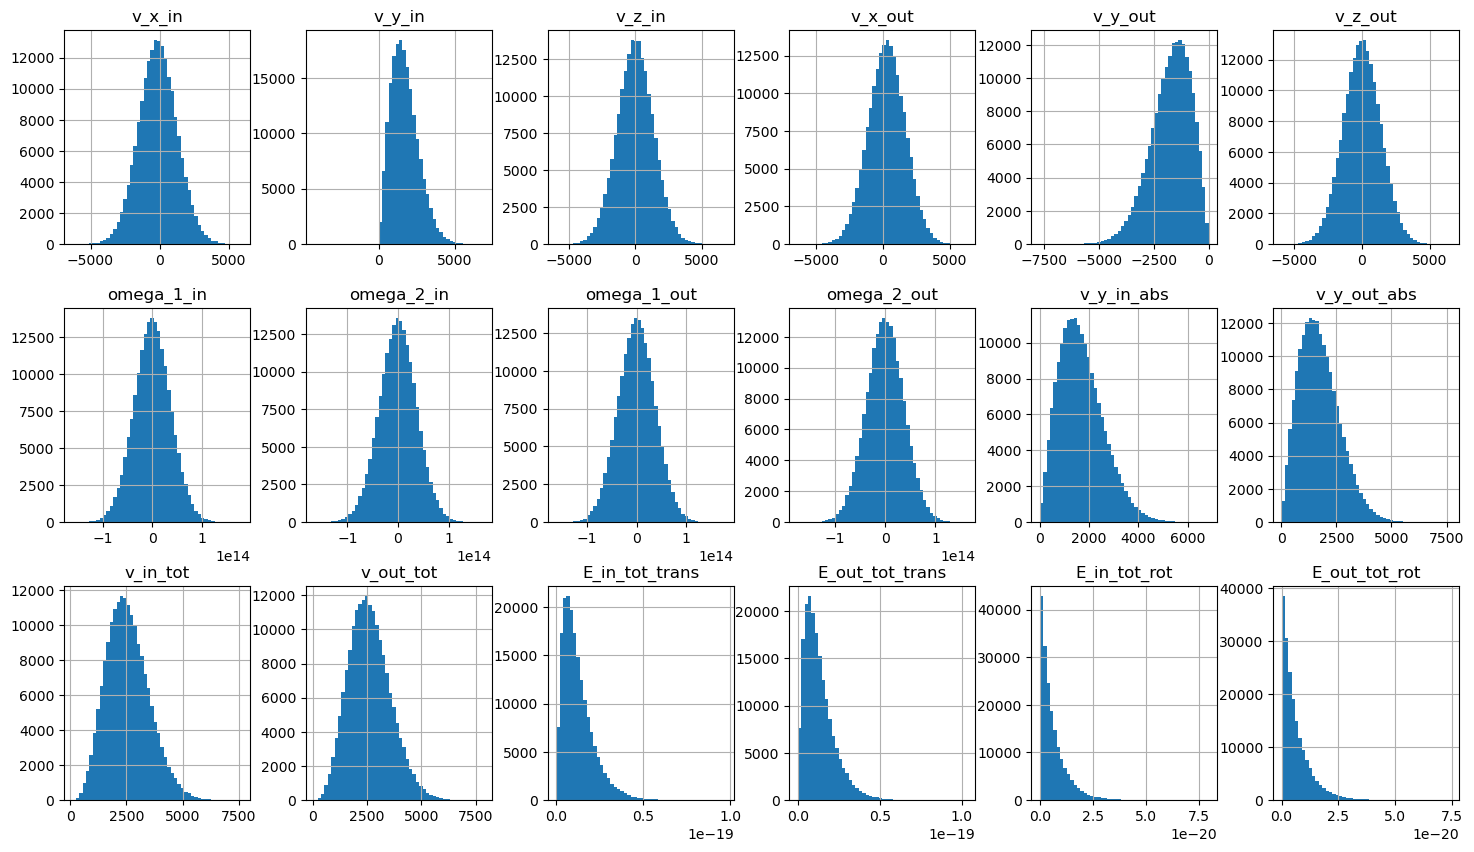

In [9]:
# Creating new columns for translational energy and other components   
df_vel['v_y_in_abs'] = np.absolute(df_vel["v_y_in"])
df_vel['v_y_out_abs'] = np.absolute(df_vel["v_y_out"])
df_vel['v_in_tot'] = (np.power(df_vel["v_x_in"],2)+ np.power(df_vel["v_y_in"],2) + np.power(df_vel["v_z_in"],2))**0.5
df_vel['v_out_tot'] = (np.power(df_vel["v_x_out"],2)+ np.power(df_vel["v_y_out"],2) + np.power(df_vel["v_z_out"],2))**0.5
df_vel['E_in_tot_trans'] = 0.5 * MASS_H2 * (np.power(df_vel["v_x_in"],2)+ np.power(df_vel["v_y_in"],2) + np.power(df_vel["v_z_in"],2))
df_vel['E_out_tot_trans'] = 0.5 * MASS_H2 * (np.power(df_vel["v_x_out"],2)+ np.power(df_vel["v_y_out"],2) + np.power(df_vel["v_z_out"],2))

# Creating columns for rotational energy
# Comment the below lines for Argon
df_vel['E_in_tot_rot'] = 0.5*I*(np.power(df_rot_vel['omega_1_in'],2)+np.power(df_rot_vel['omega_2_in'],2))
df_vel['E_out_tot_rot'] = 0.5*I*(np.power(df_rot_vel['omega_1_out'],2)+np.power(df_rot_vel['omega_2_out'],2))

# Plot the data
df_vel.hist(bins = 50, layout= (3,6), figsize= (18,10))

x = df_vel.loc[:, ].values

# Normalization
scaler = StandardScaler()
x_norm = scaler.fit_transform(x)
# scaler = MinMaxScaler(feature_range=(-1,1))
# min_max_values = scaler.fit(x)
 

# Create dataframe with normalized values
names_vel_norm = ['v_x_in', 'v_y_in', 'v_z_in', 'v_x_out', 'v_y_out', 'v_z_out', 
                  'omega_1_in', 'omega_2_in', # comment this line for Argon
                  'omega_1_out', 'omega_2_out', # comment this line for Argon
                  'v_y_in_abs', 'v_y_out_abs', 'v_in_tot','v_out_tot', 
                  'E_in_tot_trans', 'E_out_tot_trans', 
                  'E_in_tot_rot', 'E_out_tot_rot'   #comment this line for Argon
                  ]
df_vel_norm = pd.DataFrame(x_norm,columns=names_vel_norm)

# Convert dataframe to numpy arrays
x = df_vel_norm[['v_x_in', 'v_y_in', 'v_z_in', 
                 'omega_1_in', 'omega_2_in'     #comment this line for Argon
                 ]].to_numpy()
y = df_vel_norm[['v_x_out', 'v_y_out', 'v_z_out', 
                 'omega_1_out', 'omega_2_out'   #comment this line for Argon
                 ]].to_numpy()

### Selected components 

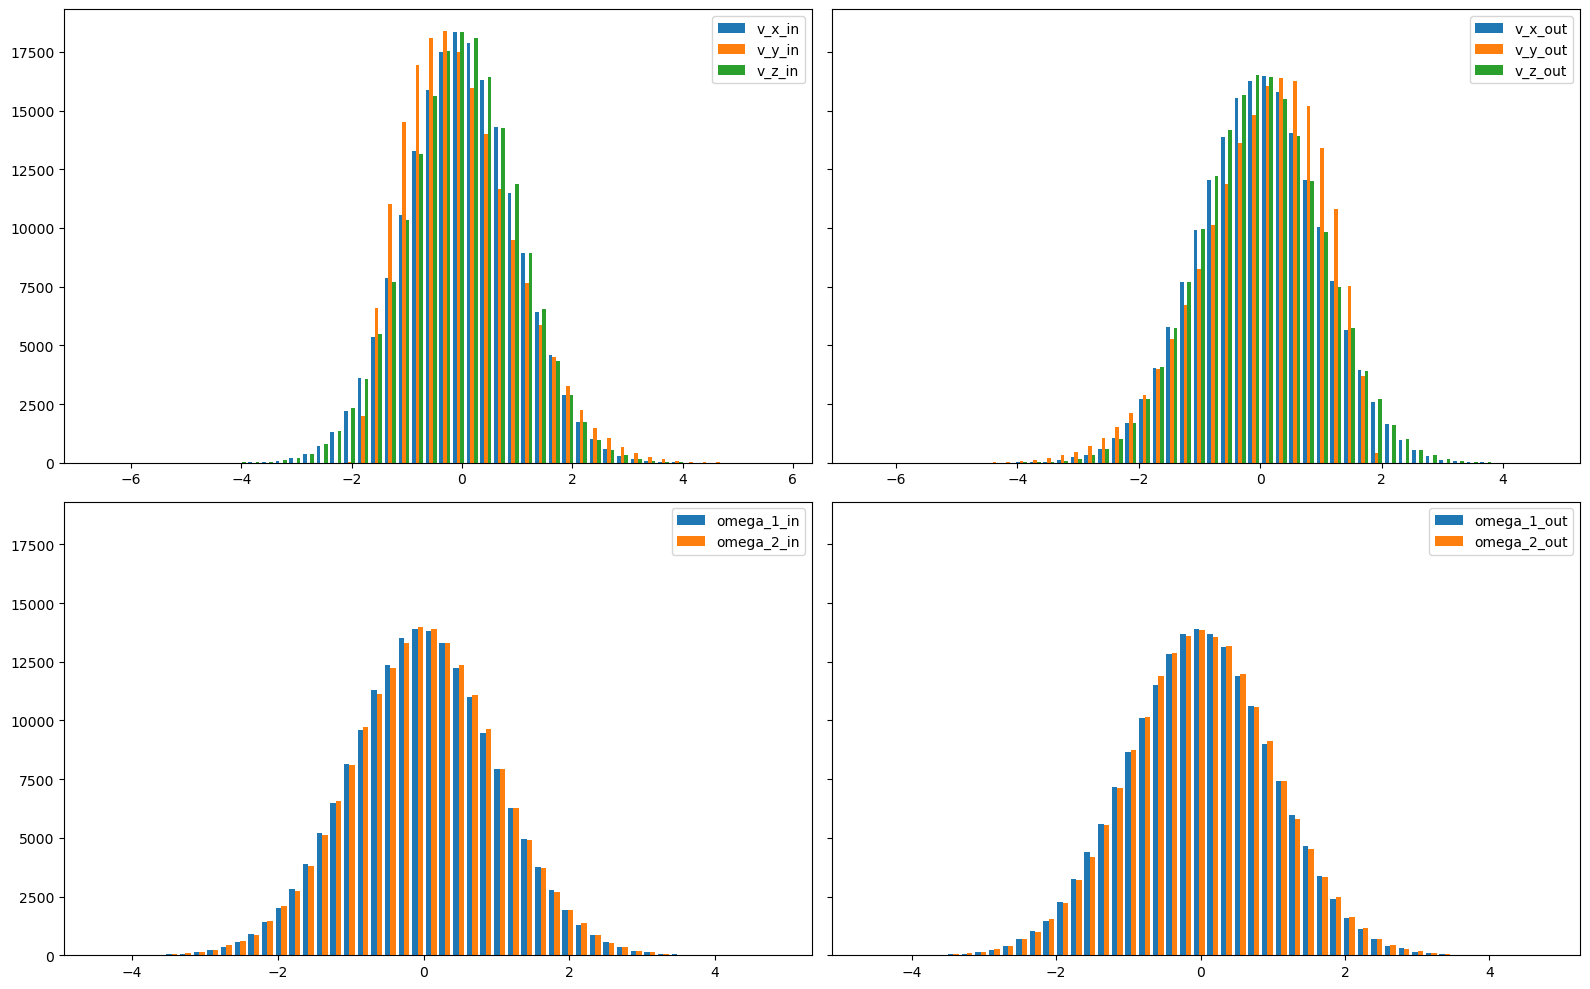

In [24]:
n_bins = 50

fig, axs = plt.subplots(2, 2, sharey=True, tight_layout=True, figsize=(16, 10))

# We can set the number of bins with the *bins* keyword argument.
axs[0][0].hist(x[:,0:3], bins=n_bins, label = ['v_x_in','v_y_in','v_z_in'])
axs[0][1].hist(y[:,0:3], bins=n_bins, label = ['v_x_out','v_y_out','v_z_out'])
axs[1][0].hist(x[:,3:5], bins=n_bins, label = ['omega_1_in','omega_2_in'])    #comment this line for Argon
axs[1][1].hist(y[:,3:5], bins=n_bins, label = ['omega_1_out','omega_2_out'])    #comment this line for Argon
axs[0][0].legend()
axs[0][1].legend()
axs[1][0].legend()
axs[1][1].legend()
plt.show()

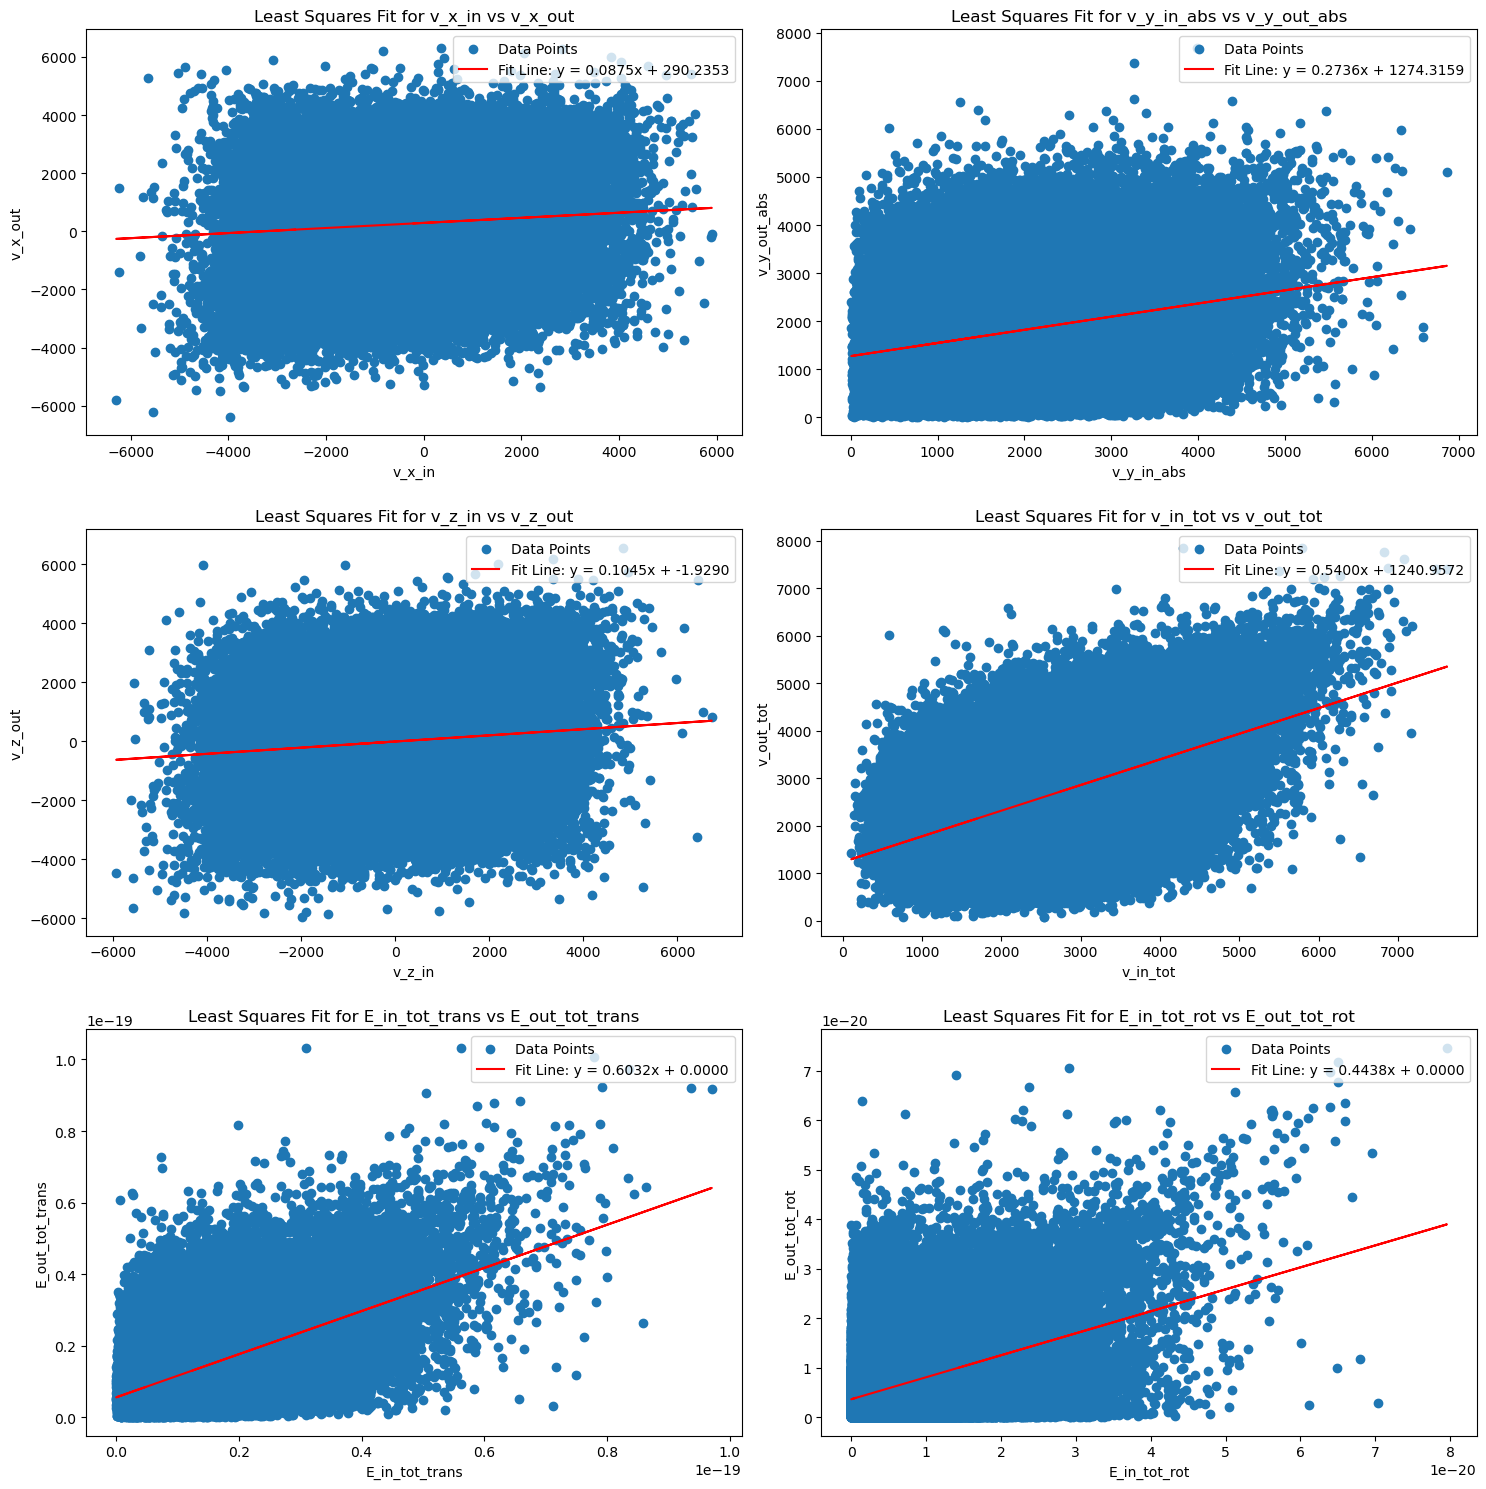

Slope, Intercept and AC for v_x_in vs v_x_out: Slope = 0.08746372089125594, Intercept = 290.23526745473515, AC = 0.912536279108744
Slope, Intercept and AC for v_y_in_abs vs v_y_out_abs: Slope = 0.27361424094498393, Intercept = 1274.315862384729, AC = 0.726385759055016
Slope, Intercept and AC for v_z_in vs v_z_out: Slope = 0.10448126715422856, Intercept = -1.9289542441751308, AC = 0.8955187328457714
Slope, Intercept and AC for v_in_tot vs v_out_tot: Slope = 0.5399878734598581, Intercept = 1240.9571997659364, AC = 0.4600121265401419
Slope, Intercept and AC for E_in_tot_trans vs E_out_tot_trans: Slope = 0.6032354533172688, Intercept = 5.530313921199659e-21, AC = 0.3967645466827312
Slope, Intercept and AC for E_in_tot_rot vs E_out_tot_rot: Slope = 0.44378130485145273, Intercept = 3.615262747026581e-21, AC = 0.5562186951485473


In [11]:
# List of column pairs to fit and plot
cols_pairs = [
    ('v_x_in', 'v_x_out'), 
    ('v_y_in_abs', 'v_y_out_abs'), 
    ('v_z_in', 'v_z_out'), 
    ('v_in_tot', 'v_out_tot'),
    ('E_in_tot_trans', 'E_out_tot_trans'),
    ('E_in_tot_rot', 'E_out_tot_rot')
    # Add more pairs as required
]

# Contour plots for all specified pairs
calculate_AC_scatter(df_vel, cols_pairs)

#### MDN

#### Make train, test and validation split

In [12]:
# Test, train and validation split
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.20, random_state=1)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.20, random_state=2)

In [13]:
# Reshaping the inputs and output tensors
x_1 = X_train[:,0].reshape((len(X_train[:]),1))
x_2 = X_train[:,1].reshape((len(X_train[:]),1))
x_3 = X_train[:,2].reshape((len(X_train[:]),1))
x_4 = X_train[:,3].reshape((len(X_train[:]),1))
x_5 = X_train[:,4].reshape((len(X_train[:]),1))
y_1 = y_train[:,0].reshape((len(y_train[:]),1))
y_2 = y_train[:,1].reshape((len(y_train[:]),1))
y_3 = y_train[:,2].reshape((len(y_train[:]),1))
y_4 = y_train[:,3].reshape((len(y_train[:]),1))
y_5 = y_train[:,4].reshape((len(y_train[:]),1))

x_1_val = X_val[:,0].reshape((len(X_val[:]),1))
x_2_val = X_val[:,1].reshape((len(X_val[:]),1))
x_3_val = X_val[:,2].reshape((len(X_val[:]),1))
x_4_val = X_val[:,3].reshape((len(X_val[:]),1))
x_5_val = X_val[:,4].reshape((len(X_val[:]),1))
y_1_val = y_val[:,0].reshape((len(y_val[:]),1))
y_2_val = y_val[:,1].reshape((len(y_val[:]),1))
y_3_val = y_val[:,2].reshape((len(y_val[:]),1))
y_4_val = y_val[:,3].reshape((len(y_val[:]),1))
y_5_val = y_val[:,4].reshape((len(y_val[:]),1))


x_1_test = X_test[:,0].reshape((len(X_test[:]),1))
x_2_test = X_test[:,1].reshape((len(X_test[:]),1))
x_3_test = X_test[:,2].reshape((len(X_test[:]),1))
x_4_test = X_test[:,3].reshape((len(X_test[:]),1))
x_5_test = X_test[:,4].reshape((len(X_test[:]),1))
y_1_test = y_test[:,0].reshape((len(y_test[:]),1))
y_2_test = y_test[:,1].reshape((len(y_test[:]),1))
y_3_test = y_test[:,2].reshape((len(y_test[:]),1))
y_4_test = y_test[:,3].reshape((len(y_test[:]),1))
y_5_test = y_test[:,4].reshape((len(y_test[:]),1))


#### Define MDN architecture

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 1, 1)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_1       │ (None, 1, 1)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_2       │ (None, 1, 1)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_3       │ (None, 1, 1)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_4       │ (None, 1, 1)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 1, 5)      │          0 │ input_layer[0][0… │
│ (Concatenate)       │                   │            │ input_layer_1[0]… │
│                     │                   │            │ input_layer_2[0]… │
│                     │                   │            │ input_layer_3[0]… │
│                     │                   │            │ input_layer_4[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 1, 32)     │        192 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 1, 32)     │      1,056 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 1, 32)     │      1,056 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 1, 32)     │      1,056 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 1, 32)     │      1,056 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 1, 32)     │      1,056 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mixture_density_ou… │ (None, 1, 162)    │      5,346 │ dense_1[0][0]     │
│ (MixtureDensityOut… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mixture_density_ou… │ (None, 1, 162)    │      5,346 │ dense_2[0][0]     │
│ (MixtureDensityOut… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mixture_density_ou… │ (None, 1, 162)    │      5,346 │ dense_3[0][0]     │
│ (MixtureDensityOut… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mixture_density_ou… │ (None, 1, 162)    │      5,346 │ dense_4[0][0]     │
│ (MixtureDensityOut… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mixture_density_ou… │ (None, 1, 162)    │      5,346 │ dense_5[0][0]     │
│ (MixtureDensityOut… │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 32,202 (125.79 KB)

 Trainable params: 32,202 (125.79 KB)

 Non-trainable params: 0 (0.00 B)

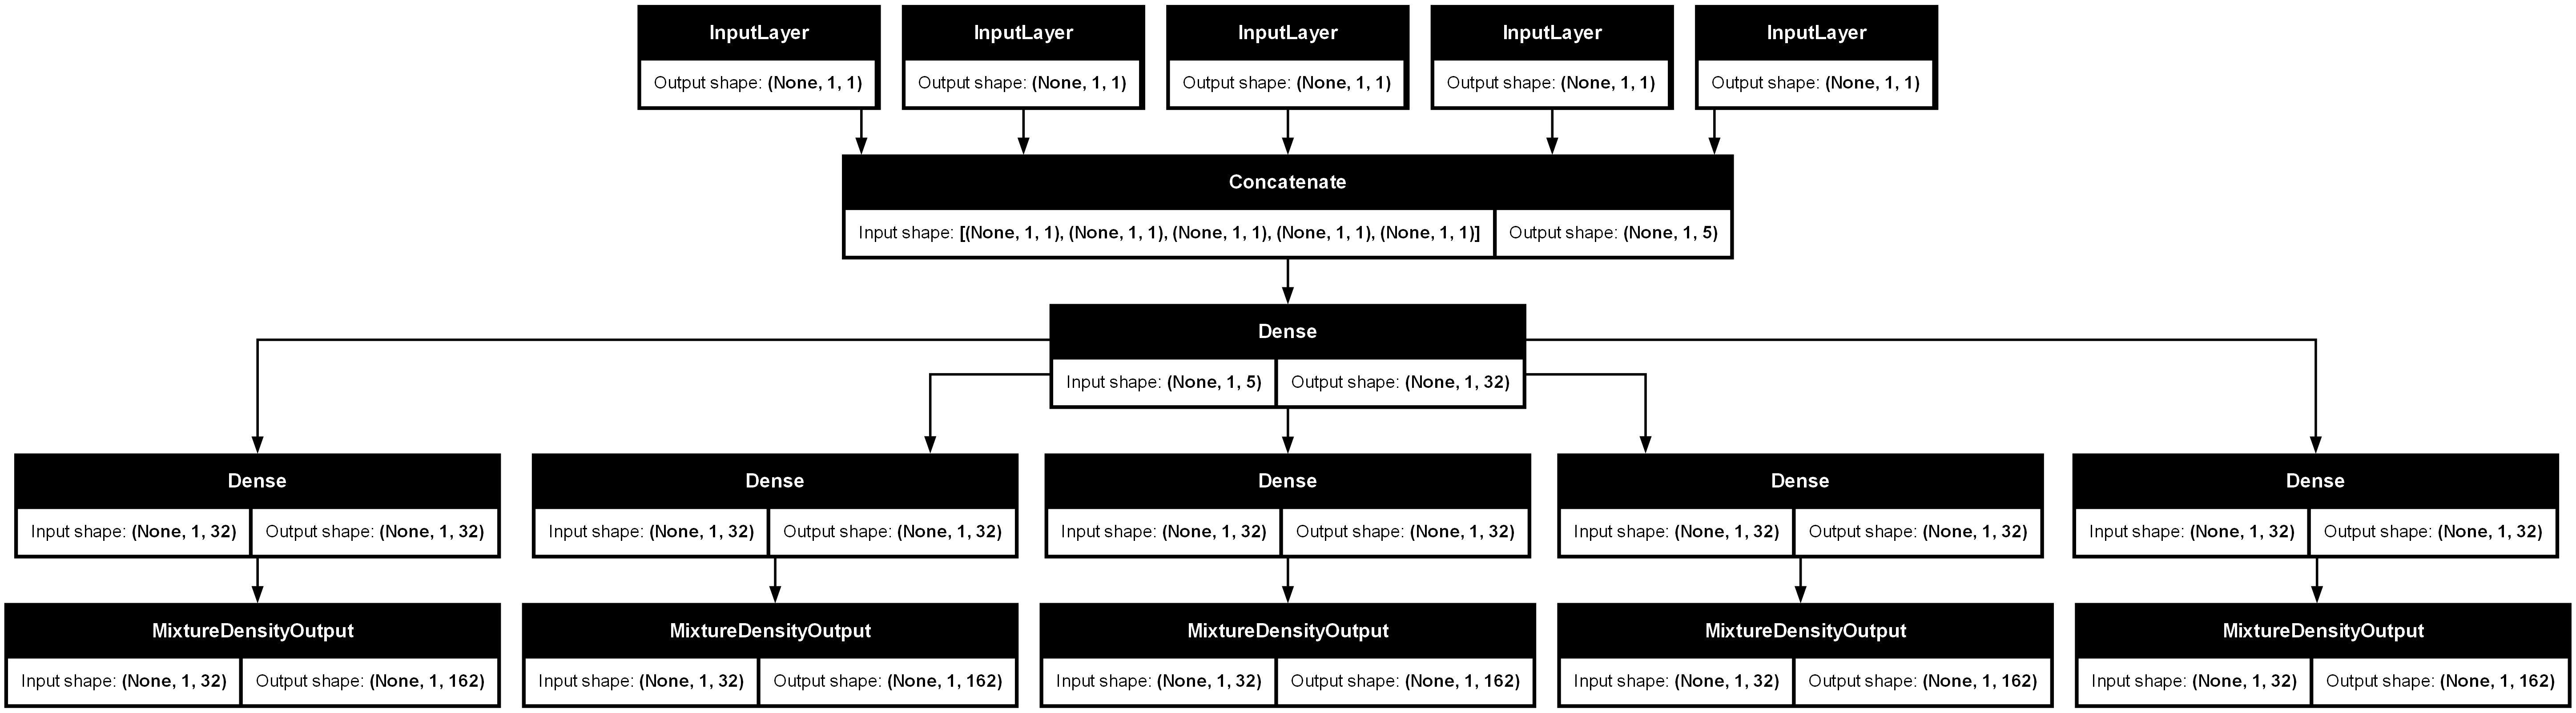

In [14]:
n_Units = 32
N_MIXES = 54
OUTPUT_DIMS = 1

lr = 0.001
loss_function = get_mixture_loss_func(OUTPUT_DIMS, N_MIXES)
optimizer = optimizers.Adam(learning_rate=lr)
activation = "leaky_relu"

def model(num_Mixes, n_Units, optimizer, loss_function):
    inputs1 = keras.Input(shape=(1, 1))
    inputs2 = keras.Input(shape=(1, 1))
    inputs3 = keras.Input(shape=(1, 1))
    inputs4 = keras.Input(shape=(1, 1))
    inputs5 = keras.Input(shape=(1, 1))

    concat_layer = layers.concatenate([inputs1, inputs2, inputs3, inputs4, inputs5])
    dense_layer = layers.Dense(units=n_Units, activation=activation)(concat_layer)

    x1 = layers.Dense(units=n_Units, activation= activation)(dense_layer)
    #x1 = layers.Dense(units=n_Units, activation=activation)(x1)
    block_1_output = MixtureDensityOutput(1, num_Mixes)(x1)

    x2 = layers.Dense(units=n_Units, activation=activation)(dense_layer)
    #x2 = layers.Dense(units=n_Units, activation=activation)(x2)
    block_2_output = MixtureDensityOutput(1, num_Mixes)(x2)


    x3 = layers.Dense(units=n_Units, activation=activation)(dense_layer)
    #x3 = layers.Dense(units=n_Units, activation=activation)(x3)
    block_3_output = MixtureDensityOutput(1, num_Mixes)(x3)

    x4 = layers.Dense(units=n_Units, activation=activation)(dense_layer)
    #x4 = layers.Dense(units=n_Units, activation=activation)(x4)
    block_4_output = MixtureDensityOutput(1, num_Mixes)(x4)

    x5 = layers.Dense(units=n_Units, activation=activation)(dense_layer)
    #x5 = layers.Dense(units=n_Units, activation=activation)(x5)
    block_5_output = MixtureDensityOutput(1, num_Mixes)(x5)

    model = keras.Model(inputs=[inputs1, inputs2, inputs3, inputs4, inputs5], 
              outputs=[block_1_output,block_2_output, block_3_output, block_4_output, block_5_output])
    model.compile(
        optimizer=optimizer,
        loss= loss_function
        )
    return model

mdn_network = model(N_MIXES, n_Units, optimizer, loss_function)

mdn_network.summary()

keras.utils.plot_model(mdn_network, show_shapes=True)

# OLD MODEL 

# n_Units = 32
# N_MIXES = 54
# OUTPUT_DIMS = 1

# lr = 0.001
# loss_function = get_mixture_loss_func(OUTPUT_DIMS, N_MIXES)
# optimizer = "adam" #optimizers.Adam(learning_rate=lr)
# activation = "relu"

# def model(num_Mixes, n_Units, optimizer, loss_function):
#     inputs1 = keras.Input(shape=(1, 1))
#     x1 = layers.Dense(units=n_Units, activation= activation)(inputs1)
#     x1 = layers.Dense(units=n_Units, activation= activation)(x1)
#     block_1_output = MixtureDensityOutput(1, num_Mixes)(x1)

#     inputs2 = keras.Input(shape=(1, 1))
#     x2 = layers.Dense(units=n_Units, activation= activation)(inputs2)
#     x2 = layers.Dense(units=n_Units, activation= activation)(x2)
#     block_2_output = MixtureDensityOutput(1, num_Mixes)(x2)

#     inputs3 = keras.Input(shape=(1, 1))
#     x3 = layers.Dense(units=n_Units, activation=activation)(inputs3)
#     x3 = layers.Dense(units=n_Units, activation=activation)(x3)
#     block_3_output = MixtureDensityOutput(1, num_Mixes)(x3)

#     inputs4 = keras.Input(shape=(1, 1))
#     x4 = layers.Dense(units=n_Units, activation=activation)(inputs4)
#     x4 = layers.Dense(units=n_Units, activation=activation)(x4)
#     block_4_output = MixtureDensityOutput(1, num_Mixes)(x4)

#     inputs5 = keras.Input(shape=(1, 1))
#     x5 = layers.Dense(units=n_Units, activation=activation)(inputs5)
#     x5 = layers.Dense(units=n_Units, activation=activation)(x5)
#     block_5_output = MixtureDensityOutput(1, num_Mixes)(x5)

#     model = keras.Model(inputs=[inputs1, inputs2, inputs3, inputs4, inputs5], outputs=[block_1_output,block_2_output, block_3_output, block_4_output, block_5_output])
#     model.compile(
#         optimizer=optimizer,
#         loss= loss_function
#         )
#     return model

# mdn_network = model(N_MIXES, n_Units, optimizer, loss_function)

# mdn_network.summary()

# keras.utils.plot_model(mdn_network, show_shapes=True)

#### Train

In [15]:
epochs = 50

history = mdn_network.fit(
    [x_1, x_2, x_3, x_4, x_5],
    [y_1, y_2, y_3, y_4, y_5],
    epochs=epochs,
    batch_size = 256,
    validation_split=0.2,
    shuffle = True,
    callbacks=[
        callbacks.EarlyStopping(monitor="loss", patience=5, restore_best_weights=True),
        callbacks.ReduceLROnPlateau(monitor="loss", patience=2),
    ],
)

Epoch 1/50
369/369 ━━━━━━━━━━━━━━━━━━━━ 220s 122ms/step - loss: 6.9175 - val_loss: 6.7253 - learning_rate: 0.0010
Epoch 2/50
369/369 ━━━━━━━━━━━━━━━━━━━━ 9s 25ms/step - loss: 6.7128 - val_loss: 6.7104 - learning_rate: 0.0010
Epoch 3/50
369/369 ━━━━━━━━━━━━━━━━━━━━ 10s 28ms/step - loss: 6.7070 - val_loss: 6.7088 - learning_rate: 0.0010
Epoch 4/50
369/369 ━━━━━━━━━━━━━━━━━━━━ 10s 28ms/step - loss: 6.6952 - val_loss: 6.7023 - learning_rate: 0.0010
Epoch 5/50
369/369 ━━━━━━━━━━━━━━━━━━━━ 10s 28ms/step - loss: 6.6893 - val_loss: 6.7014 - learning_rate: 0.0010
Epoch 6/50
369/369 ━━━━━━━━━━━━━━━━━━━━ 11s 29ms/step - loss: 6.6884 - val_loss: 6.7006 - learning_rate: 0.0010
Epoch 7/50
369/369 ━━━━━━━━━━━━━━━━━━━━ 12s 32ms/step - loss: 6.6856 - val_loss: 6.6992 - learning_rate: 0.0010
Epoch 8/50
369/369 ━━━━━━━━━━━━━━━━━━━━ 12775s 65ms/step - loss: 6.6768 - val_loss: 6.6985 - learning_rate: 0.0010
Epoch 9/50
369/369 ━━━━━━━━━━━━━━━━━━━━ 15s 41ms/step - loss: 6.6794 - val_loss: 6.6984 - learning_r

### Hyperparameter tuning - Defining search space and optimization

In [23]:
def model(hp, num_Mixes = 20, n_Units = 32, activation = 'relu',  dropout = False, dropout_rate = 0.2, optimizer = "", lr = 0.001):

    inputs1 = keras.Input(shape=(1, 1))
    inputs2 = keras.Input(shape=(1, 1))
    inputs3 = keras.Input(shape=(1, 1))
    inputs4 = keras.Input(shape=(1, 1))
    inputs5 = keras.Input(shape=(1, 1))

    concat_layer = layers.concatenate([inputs1, inputs2, inputs3, inputs4, inputs5])
    dense_layer = layers.Dense(units=n_Units, activation=activation)(concat_layer)

    x1 = layers.Dense(units=n_Units, activation= activation)(dense_layer)
    #x1 = layers.Dense(units=n_Units, activation=activation)(x1)
    block_1_output = MixtureDensityOutput(1, num_Mixes)(x1)

    x2 = layers.Dense(units=n_Units, activation=activation)(dense_layer)
    #x2 = layers.Dense(units=n_Units, activation=activation)(x2)
    block_2_output = MixtureDensityOutput(1, num_Mixes)(x2)


    x3 = layers.Dense(units=n_Units, activation=activation)(dense_layer)
    #x3 = layers.Dense(units=n_Units, activation=activation)(x3)
    block_3_output = MixtureDensityOutput(1, num_Mixes)(x3)

    x4 = layers.Dense(units=n_Units, activation=activation)(dense_layer)
    #x4 = layers.Dense(units=n_Units, activation=activation)(x4)
    block_4_output = MixtureDensityOutput(1, num_Mixes)(x4)

    x5 = layers.Dense(units=n_Units, activation=activation)(dense_layer)
    #x5 = layers.Dense(units=n_Units, activation=activation)(x5)
    block_5_output = MixtureDensityOutput(1, num_Mixes)(x5)

    model = keras.Model(inputs=[inputs1, inputs2, inputs3, inputs4, inputs5], 
              outputs=[block_1_output,block_2_output, block_3_output, block_4_output, block_5_output])
    
    if optimizer == 'Adam':
        optimizer = optimizers.Adam(learning_rate=lr)
    elif optimizer == 'AdamW':
        optimizer = optimizers.AdamW(learning_rate=lr)
    elif optimizer == 'Nadam':
        optimizer = optimizers.Nadam(learning_rate=lr)
    elif optimizer == 'Adadelta':
        optimizer = optimizers.Adadelta(learning_rate=lr)        
    else:
        optimizer = optimizers.Adam(learning_rate=lr)
    
    model.compile(
        optimizer=optimizer,
        loss= get_mixture_loss_func(1, num_Mixes)
        )
    return model

# Define hyper-parameter search space
def build_model(hp):

    # Choices for number of Mixtures - an important advantage of using MDN
    num_Mixes = hp.Int("num_Mixes", min_value=10, max_value=100, step=1)
    
    # Choices for number of layers, excluding output layer
    num_Layers = hp.Int("num_layers", min_value=1, max_value=10, step=1)

    # Choices for number of layers, excluding output layer
    num_Units = hp.Int("num_layers", min_value=32, max_value=32, step=32)   

    # Choices of activation
    activation = hp.Choice("activation", ["relu"])      # ["relu", "tanh", "sigmoid", "leaky_relu", "elu"]
    
    # Choice on dropout
    # dropout = hp.Boolean("dropout", default = True)

    # Choices on dropout rate
    # dropout_rate = hp.Float ("dropout_rate", min_value = 0.05, max_value = 0.75, step = 0.02)

    # Choices on learning rate
    optimizer = hp.Choice("optimizer", ["adam"])  # ["Adam", "AdamW", "Nadam", "Adadelta"]
    
    # Call existing model-building code with the hyperparameter values.
    mdn_network = model(
        hp, 
        num_Mixes=num_Mixes, 
        n_Units = num_Units,  
        activation=activation, 
        #num_Layers=num_Layers,
        #dropout_rate= dropout_rate, 
        #dropout=dropout,  
        optimizer = optimizer
    )
    return mdn_network


build_model(keras_tuner.HyperParameters())

# Directory to store the models during hyper-parameter tuning 
directory = r"D:\OneDrive - TU Eindhoven\Quartile_4\4AI000_Machine learning for Multi-physics modelling and design\Materials_for_ML_assignment_2024\models"

# Bayesion optimization 

tuner = keras_tuner.BayesianOptimization(
    hypermodel= build_model,
    max_trials= 40,
    objective = "loss",
    alpha=0.0001,
    beta=2.6,
    seed= 1,
    tune_new_entries=True,
    allow_new_entries=True,
    max_retries_per_trial=0,
    max_consecutive_failed_trials=3,
    project_name="models_4AI000",
    overwrite = True,
)

tuner.search_space_summary()

Search space summary
Default search space size: 4
num_Mixes (Int)
{'default': None, 'conditions': [], 'min_value': 10, 'max_value': 100, 'step': 1, 'sampling': 'linear'}
num_layers (Int)
{'default': None, 'conditions': [], 'min_value': 1, 'max_value': 10, 'step': 1, 'sampling': 'linear'}
activation (Choice)
{'default': 'relu', 'conditions': [], 'values': ['relu'], 'ordered': False}
optimizer (Choice)
{'default': 'adam', 'conditions': [], 'values': ['adam'], 'ordered': False}


In [ ]:
# def model(hp, num_Mixes = 20, num_Layers = 2, activation = "Relu", dropout = False, dropout_rate = 0.2, optimizer = ""):
#     model =  keras.Sequential()
    
#     for i in range(1, num_Layers+1):
#         model.add(
#             layers.Dense(
#                 units=hp.Int(f"units_{i}", min_value=32, max_value=512, step=32),
#                 activation=activation)
#         )
#         if dropout:
#             model.add(layers.Dropout(dropout_rate=0.2))   
    
#     model.add(MixtureDensityOutput(OUTPUT_DIMS, num_Mixes))

#     if optimizer == 'Adam':
#         optimizer = optimizers.Adam(learning_rate=lr)
#     elif optimizer == 'AdamW':
#         optimizer = optimizers.AdamW(learning_rate=lr)
#     elif optimizer == 'Nadam':
#         optimizer = optimizers.Nadam(learning_rate=lr)
#     elif optimizer == 'Adadelta':
#         optimizer = optimizers.Adadelta(learning_rate=lr)        
#     else:
#         optimizer = optimizers.Adam(learning_rate=lr)

#     model.compile(
#         optimizer = optimizer,
#         loss= get_mixture_loss_func(OUTPUT_DIMS, num_Mixes),
#     )
#     return model

# # Define hyper-parameter search space
# def build_model(hp):

#     # Choices for number of Mixtures - an important advantage of using MDN
#     num_Mixes = hp.Int("num_Mixes", min_value=10, max_value=50, step=1)
    
#     # Choices for number of layers
#     num_Layers = hp.Int("num_layers", min_value=1, max_value=2, step=1)    # hp.Int("num_layers", min_value=1, max_value=10, step=1)

#     # Choices of activation
#     activation = hp.Choice("activation", ["relu", "leaky_relu"])      # ["relu", "tanh", "sigmoid", "leaky_relu", "elu"]
    
#     # Choice on dropout
#     dropout = hp.Boolean("dropout", [True, False])

#     # Choices on dropout rate
#     dropout_rate = hp.Float ("dropout_rate", min_value = 0.0, max_value = 0.5, step = 0.2)   # hp.Float ("dropout_rate", min_value = 0.05, max_value = 0.75, step = 0.02)

#     # Choices on learning rate
#     optimizer = hp.Choice("optimizer", ["Adam", "Nadam", "Adadelta"])  # ["Adam", "AdamW", "Nadam", "Adadelta"]
    
#     # Call existing model-building code with the hyperparameter values.
#     mdn_network = model(
#         hp, num_Mixes=num_Mixes, 
#         num_Layers=num_Layers, 
#         activation=activation, 
#         dropout_rate= dropout_rate, 
#         dropout=dropout,  
#         optimizer = optimizer
#     )
#     return mdn_network


# build_model(keras_tuner.HyperParameters())

# # Directory to store the models during hyper-parameter tuning 
# directory = r"D:\OneDrive - TU Eindhoven\Quartile_4\4AI000_Machine learning for Multi-physics modelling and design\Materials_for_ML_assignment_2024\models"

# tuner = keras_tuner.BayesianOptimization(
#     hypermodel= build_model,
#     max_trials= 40,
#     objective = "loss",
#     alpha=0.0001,
#     beta=2.6,
#     seed= 1,
#     tune_new_entries=True,
#     allow_new_entries=True,
#     max_retries_per_trial=0,
#     max_consecutive_failed_trials=3,
#     project_name="models_4AI000",
#     overwrite = True,
# )

# # tuner = keras_tuner.RandomSearch(
# #     hypermodel=build_model,
# #     objective="loss",
# #     max_trials=3,
# #     executions_per_trial=2,
# #     overwrite=True,
# #     directory= directory,
# #     project_name="4AI000",
# # )

# tuner.search_space_summary()

### Perform hyper-parameter tuning

In [ ]:
epochs = 10
tuner.search([x_1, x_2, x_3], [y_1, y_2, y_3], epochs= epochs, validation_data=([x_1_val, x_2_val, x_3_val],[y_1_val, y_2_val, y_3_val]))

Trial 13 Complete [00h 03m 50s]

Best loss So Far: -2.173656702041626
Total elapsed time: 01h 31m 15s


#### Compile model with best hyper-parameters 

In [ ]:
best_hps = tuner.get_best_hyperparameters(5)
# Build the model with the best hp.
mdn_network = build_model(best_hps[0])

print("The best hyper-parameters are")
print(best_hps[0].values)

The best hyper-parameters are
{'num_Mixes': 44, 'num_layers': 1, 'activation': 'relu', 'units_1': 32}


### Summary of best model

In [ ]:
models = tuner.get_best_models(num_models=2)
best_model = models[0]
best_model.summary()

c:\Users\HP\anaconda3\envs\experiments\Lib\site-packages\keras\src\saving\saving_lib.py:415: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 32)             │            64 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mixture_density_output          │ (None, 132)            │         4,356 │
│ (MixtureDensityOutput)          │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,420 (17.27 KB)

 Trainable params: 4,420 (17.27 KB)

 Non-trainable params: 0 (0.00 B)

### Training the best model

In [ ]:
history = mdn_network.fit(
    [x_1, x_2, x_3, x_4, x_5],
    [y_1, y_2, y_3, y_4, y_5],
    epochs=100,
    batch_size = 128,
    validation_split=0.05,
    shuffle = True,
    callbacks=[
        callbacks.EarlyStopping(monitor="loss", patience=10, restore_best_weights=True),
        callbacks.ReduceLROnPlateau(monitor="loss", patience=5),
    ],
)

Epoch 1/100


ValueError: Layer 'functional_1' expected 3 input(s). Received 1 instead.

### Plot Loss

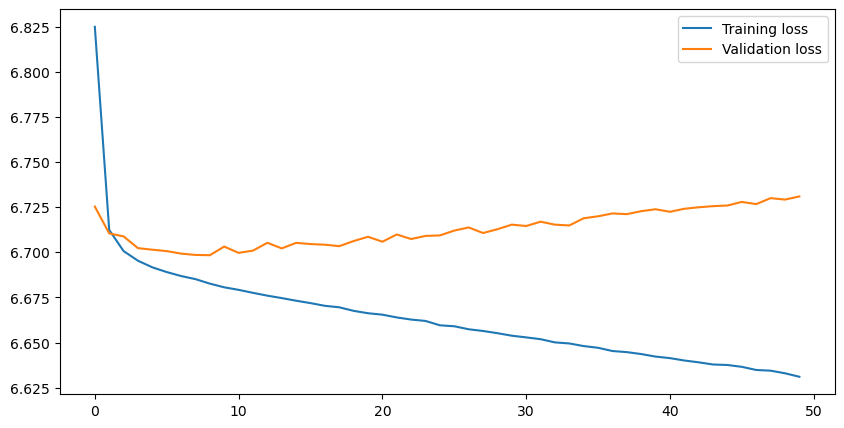

In [16]:
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label = 'Training loss')
plt.plot(history.history['val_loss'], label = 'Validation loss')
plt.legend()
plt.show()

In [17]:
y_pred_mixture = mdn_network.predict((x_1_test,x_2_test, x_3_test, x_4_test, x_5_test))

1151/1151 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step


In [18]:
# Reshape and sampling
y_new = []
y_samples = []
for i in range(len(y_pred_mixture)):
    y_new.append(y_pred_mixture[i].reshape((len(y_pred_mixture[0]),N_MIXES*3)))
    y_samples.append(np.apply_along_axis(sample_from_output, 1, y_new[i], 1, N_MIXES, temp=1.0))
    y_samples[i] = y_samples[i].reshape((len(y_samples[i])))    

In [19]:
# Create data frame with results and original input/output velocities for plotting purpose

df_results_norm = pd.DataFrame(y_samples).transpose()
df_results_norm.rename(columns = {0:'v_x_out_pred', 1:'v_y_out_pred',2:'v_z_out_pred', 3:'omega_1_out_pred', 4:'omega_2_out_pred' }, inplace = True)
df_results_norm['v_x_in'] = x_1_test
df_results_norm['v_y_in'] = x_2_test
df_results_norm['v_z_in'] = x_3_test
df_results_norm['omega_1_in'] = x_4_test
df_results_norm['omega_2_in'] = x_5_test
df_results_norm['v_x_out'] = y_1_test
df_results_norm['v_y_out'] = y_2_test
df_results_norm['v_z_out'] = y_3_test 
df_results_norm['omega_1_out'] = y_4_test
df_results_norm['omega_2_out'] = y_5_test


# Calculate translational and rotational energies for test and predicted data
df_results_norm['v_y_in_abs'] = np.absolute(df_results_norm["v_y_in"])
df_results_norm['v_y_out_abs'] = np.absolute(df_results_norm["v_y_out"])
df_results_norm['v_y_out_abs_pred'] = np.absolute(df_results_norm["v_y_out_pred"])
df_results_norm['v_in_tot'] = (np.power(df_results_norm["v_x_in"],2)+ np.power(df_results_norm["v_y_in"],2) + np.power(df_results_norm["v_z_in"],2))**0.5
df_results_norm['v_out_tot'] = (np.power(df_results_norm["v_x_out"],2)+ np.power(df_results_norm["v_y_out"],2) + np.power(df_results_norm["v_z_out"],2))**0.5
df_results_norm['E_in_tot_trans'] = 0.5 * MASS_H2 * (np.power(df_results_norm["v_x_in"],2)+ np.power(df_results_norm["v_y_in"],2) + np.power(df_results_norm["v_z_in"],2))
df_results_norm['E_out_tot_trans'] = 0.5 * MASS_H2 * (np.power(df_results_norm["v_x_out"],2)+ np.power(df_results_norm["v_y_out"],2) + np.power(df_results_norm["v_z_out"],2))
df_results_norm['E_out_tot_trans_pred'] = 0.5 * MASS_H2 * (np.power(df_results_norm["v_x_out_pred"],2)+ np.power(df_results_norm["v_y_out_pred"],2) + np.power(df_results_norm["v_z_out_pred"],2))
df_results_norm['E_in_tot_rot'] = 0.5*I*(np.power(df_results_norm['omega_1_in'],2)+np.power(df_results_norm['omega_2_in'],2))
df_results_norm['E_out_tot_rot'] = 0.5*I*(np.power(df_results_norm['omega_1_out'],2)+np.power(df_results_norm['omega_2_out'],2))
df_results_norm['E_out_tot_rot_pred'] = 0.5*I*(np.power(df_results_norm['omega_1_out_pred'],2)+np.power(df_results_norm['omega_2_out_pred'],2))

#### Plot original and predicted data

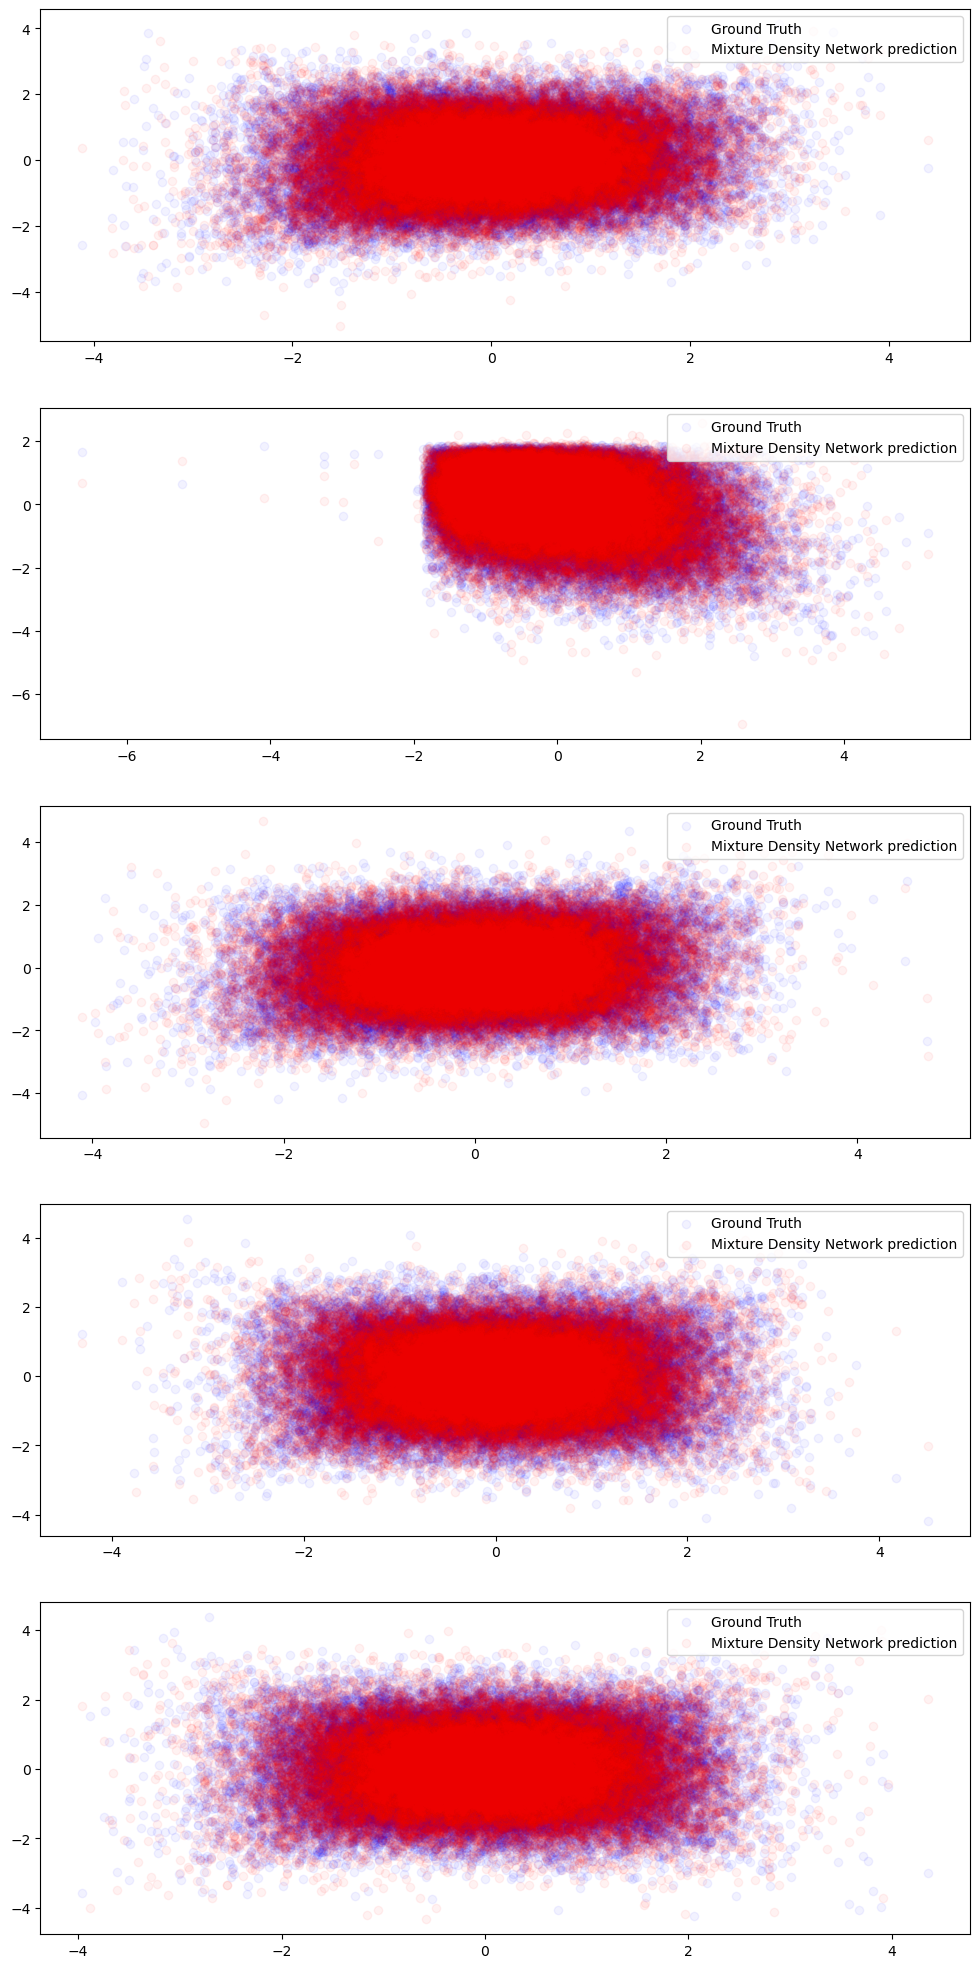

In [20]:
fig, axs = plt.subplots(5, 1, figsize = (12,25))
axs[0].scatter(df_results_norm['v_x_in'], df_results_norm['v_x_out'], alpha=0.05, color="blue", label="Ground Truth")
axs[0].scatter(df_results_norm['v_x_in'], df_results_norm['v_x_out_pred'], color="red", alpha=0.05, label="Mixture Density Network prediction")
axs[0].legend(loc = 1)
axs[1].scatter(df_results_norm['v_y_in'], df_results_norm['v_y_out'], alpha=0.05, color="blue", label="Ground Truth")
axs[1].scatter(df_results_norm['v_y_in'], df_results_norm['v_y_out_pred'], color="red", alpha=0.05, label="Mixture Density Network prediction")
axs[1].legend(loc = 1)
axs[2].scatter(df_results_norm['v_z_in'], df_results_norm['v_z_out'], alpha=0.05, color="blue", label="Ground Truth")
axs[2].scatter(df_results_norm['v_z_in'], df_results_norm['v_z_out_pred'], color="red", alpha=0.05, label="Mixture Density Network prediction")
axs[2].legend(loc = 1)
axs[3].scatter(df_results_norm['omega_1_in'], df_results_norm['omega_1_out'], alpha=0.05, color="blue", label="Ground Truth")
axs[3].scatter(df_results_norm['omega_1_in'], df_results_norm['omega_1_out_pred'], color="red", alpha=0.05, label="Mixture Density Network prediction")
axs[3].legend(loc = 1)
axs[4].scatter(df_results_norm['omega_2_in'], df_results_norm['omega_2_out'], alpha=0.05, color="blue", label="Ground Truth")
axs[4].scatter(df_results_norm['omega_2_in'], df_results_norm['omega_2_out_pred'], color="red", alpha=0.05, label="Mixture Density Network prediction")
axs[4].legend(loc = 1)



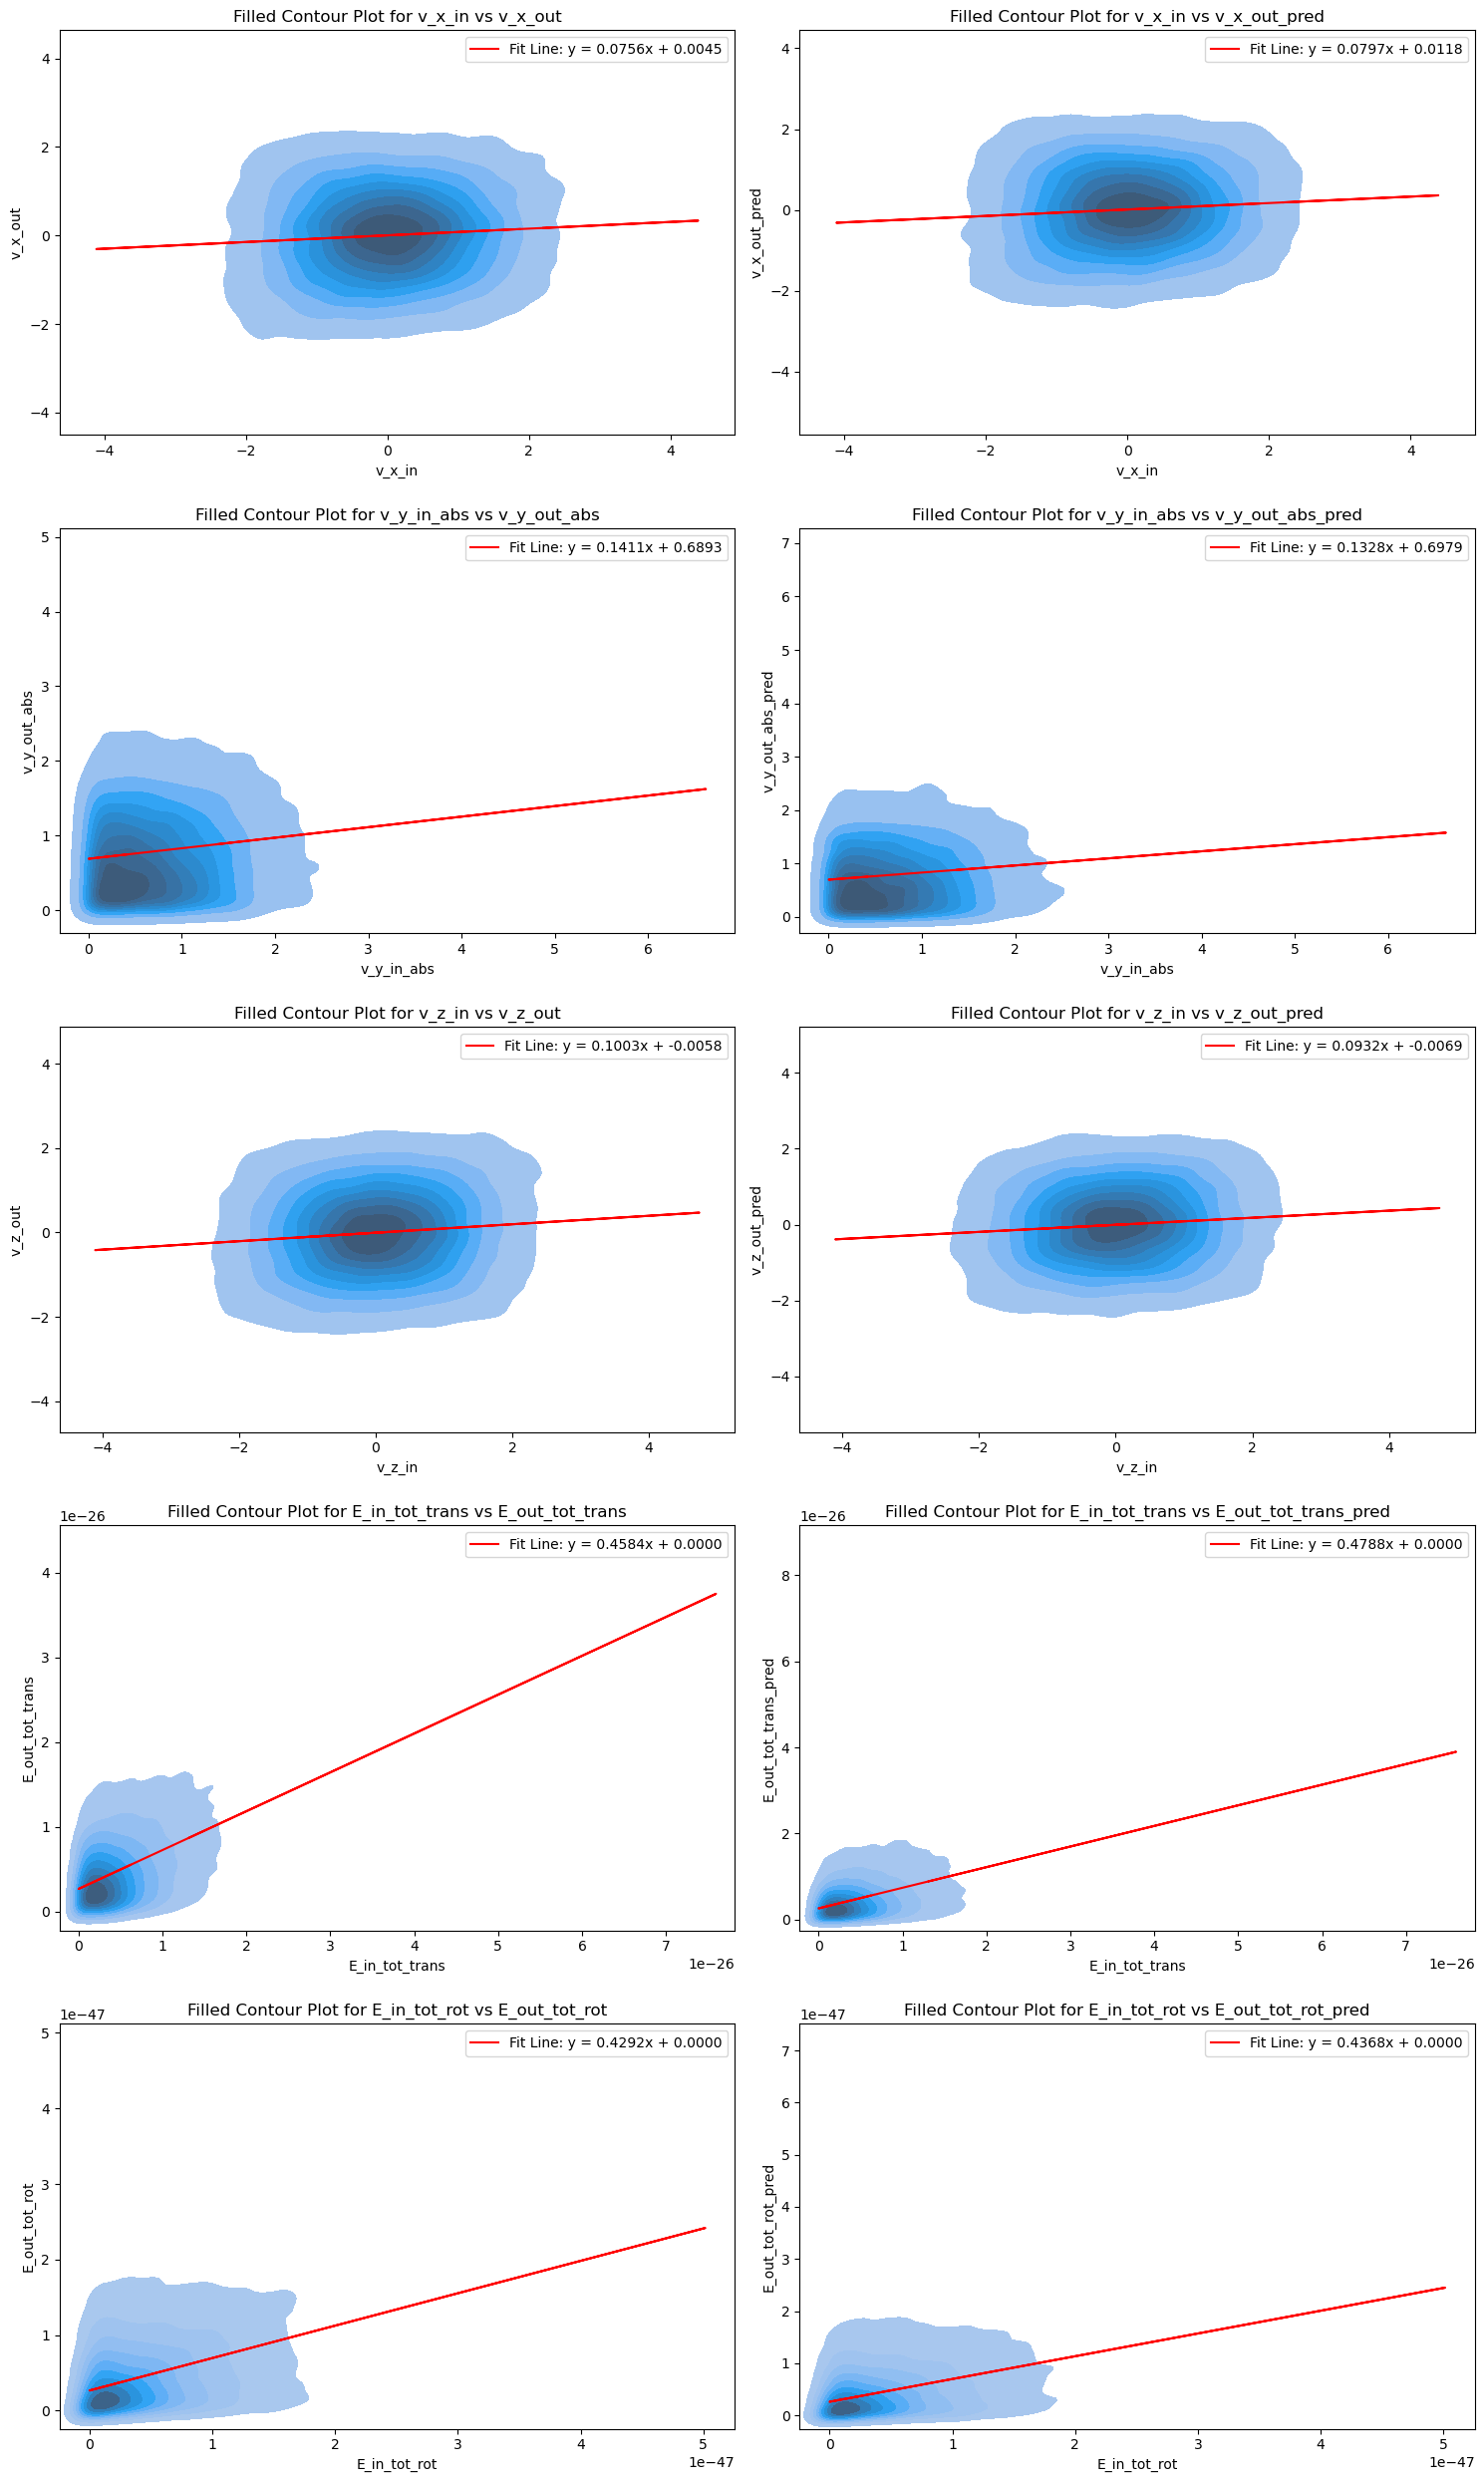

Slope, Intercept and AC for v_x_in vs v_x_out: Slope = 0.07557869087359884, Intercept = 0.004505654730686211, AC = 0.9244213091264012
Slope, Intercept and AC for v_x_in vs v_x_out_pred: Slope = 0.07974174932167567, Intercept = 0.011802121445963638, AC = 0.9202582506783243
Slope, Intercept and AC for v_y_in_abs vs v_y_out_abs: Slope = 0.1410837921725251, Intercept = 0.6893445383685256, AC = 0.8589162078274749
Slope, Intercept and AC for v_y_in_abs vs v_y_out_abs_pred: Slope = 0.13282466857347003, Intercept = 0.6979124191759937, AC = 0.86717533142653
Slope, Intercept and AC for v_z_in vs v_z_out: Slope = 0.10028640355357218, Intercept = -0.005754244222582344, AC = 0.8997135964464278
Slope, Intercept and AC for v_z_in vs v_z_out_pred: Slope = 0.09315726485343534, Intercept = -0.006867109970945797, AC = 0.9068427351465647
Slope, Intercept and AC for E_in_tot_trans vs E_out_tot_trans: Slope = 0.45838463166616383, Intercept = 2.695426972583229e-27, AC = 0.5416153683338362
Slope, Intercept an

In [21]:
# List of column pairs to fit and plot
cols_pairs = [
    ('v_x_in', 'v_x_out'),
    ('v_x_in', 'v_x_out_pred'),   
    ('v_y_in_abs', 'v_y_out_abs'),
    ('v_y_in_abs', 'v_y_out_abs_pred'),
    ('v_z_in', 'v_z_out'), 
    ('v_z_in', 'v_z_out_pred'), 
    ('E_in_tot_trans', 'E_out_tot_trans'),
    ('E_in_tot_trans', 'E_out_tot_trans_pred'),
    ('E_in_tot_rot', 'E_out_tot_rot'),
    ('E_in_tot_rot', 'E_out_tot_rot_pred') 
    # Add more pairs as required
]

calculate_AC_contor(df_results_norm, cols_pairs)

# cols_pairs1 = [
#     ('v_y_in', 'v_y_out')
# ]
# calculate_AC_scatter(df_test_liao, cols_pairs1)

# cols_pairs2 = [
#     ('v_y_in', 'v_y_out')
# ]
# calculate_AC_scatter(df_results_liao, cols_pairs2)

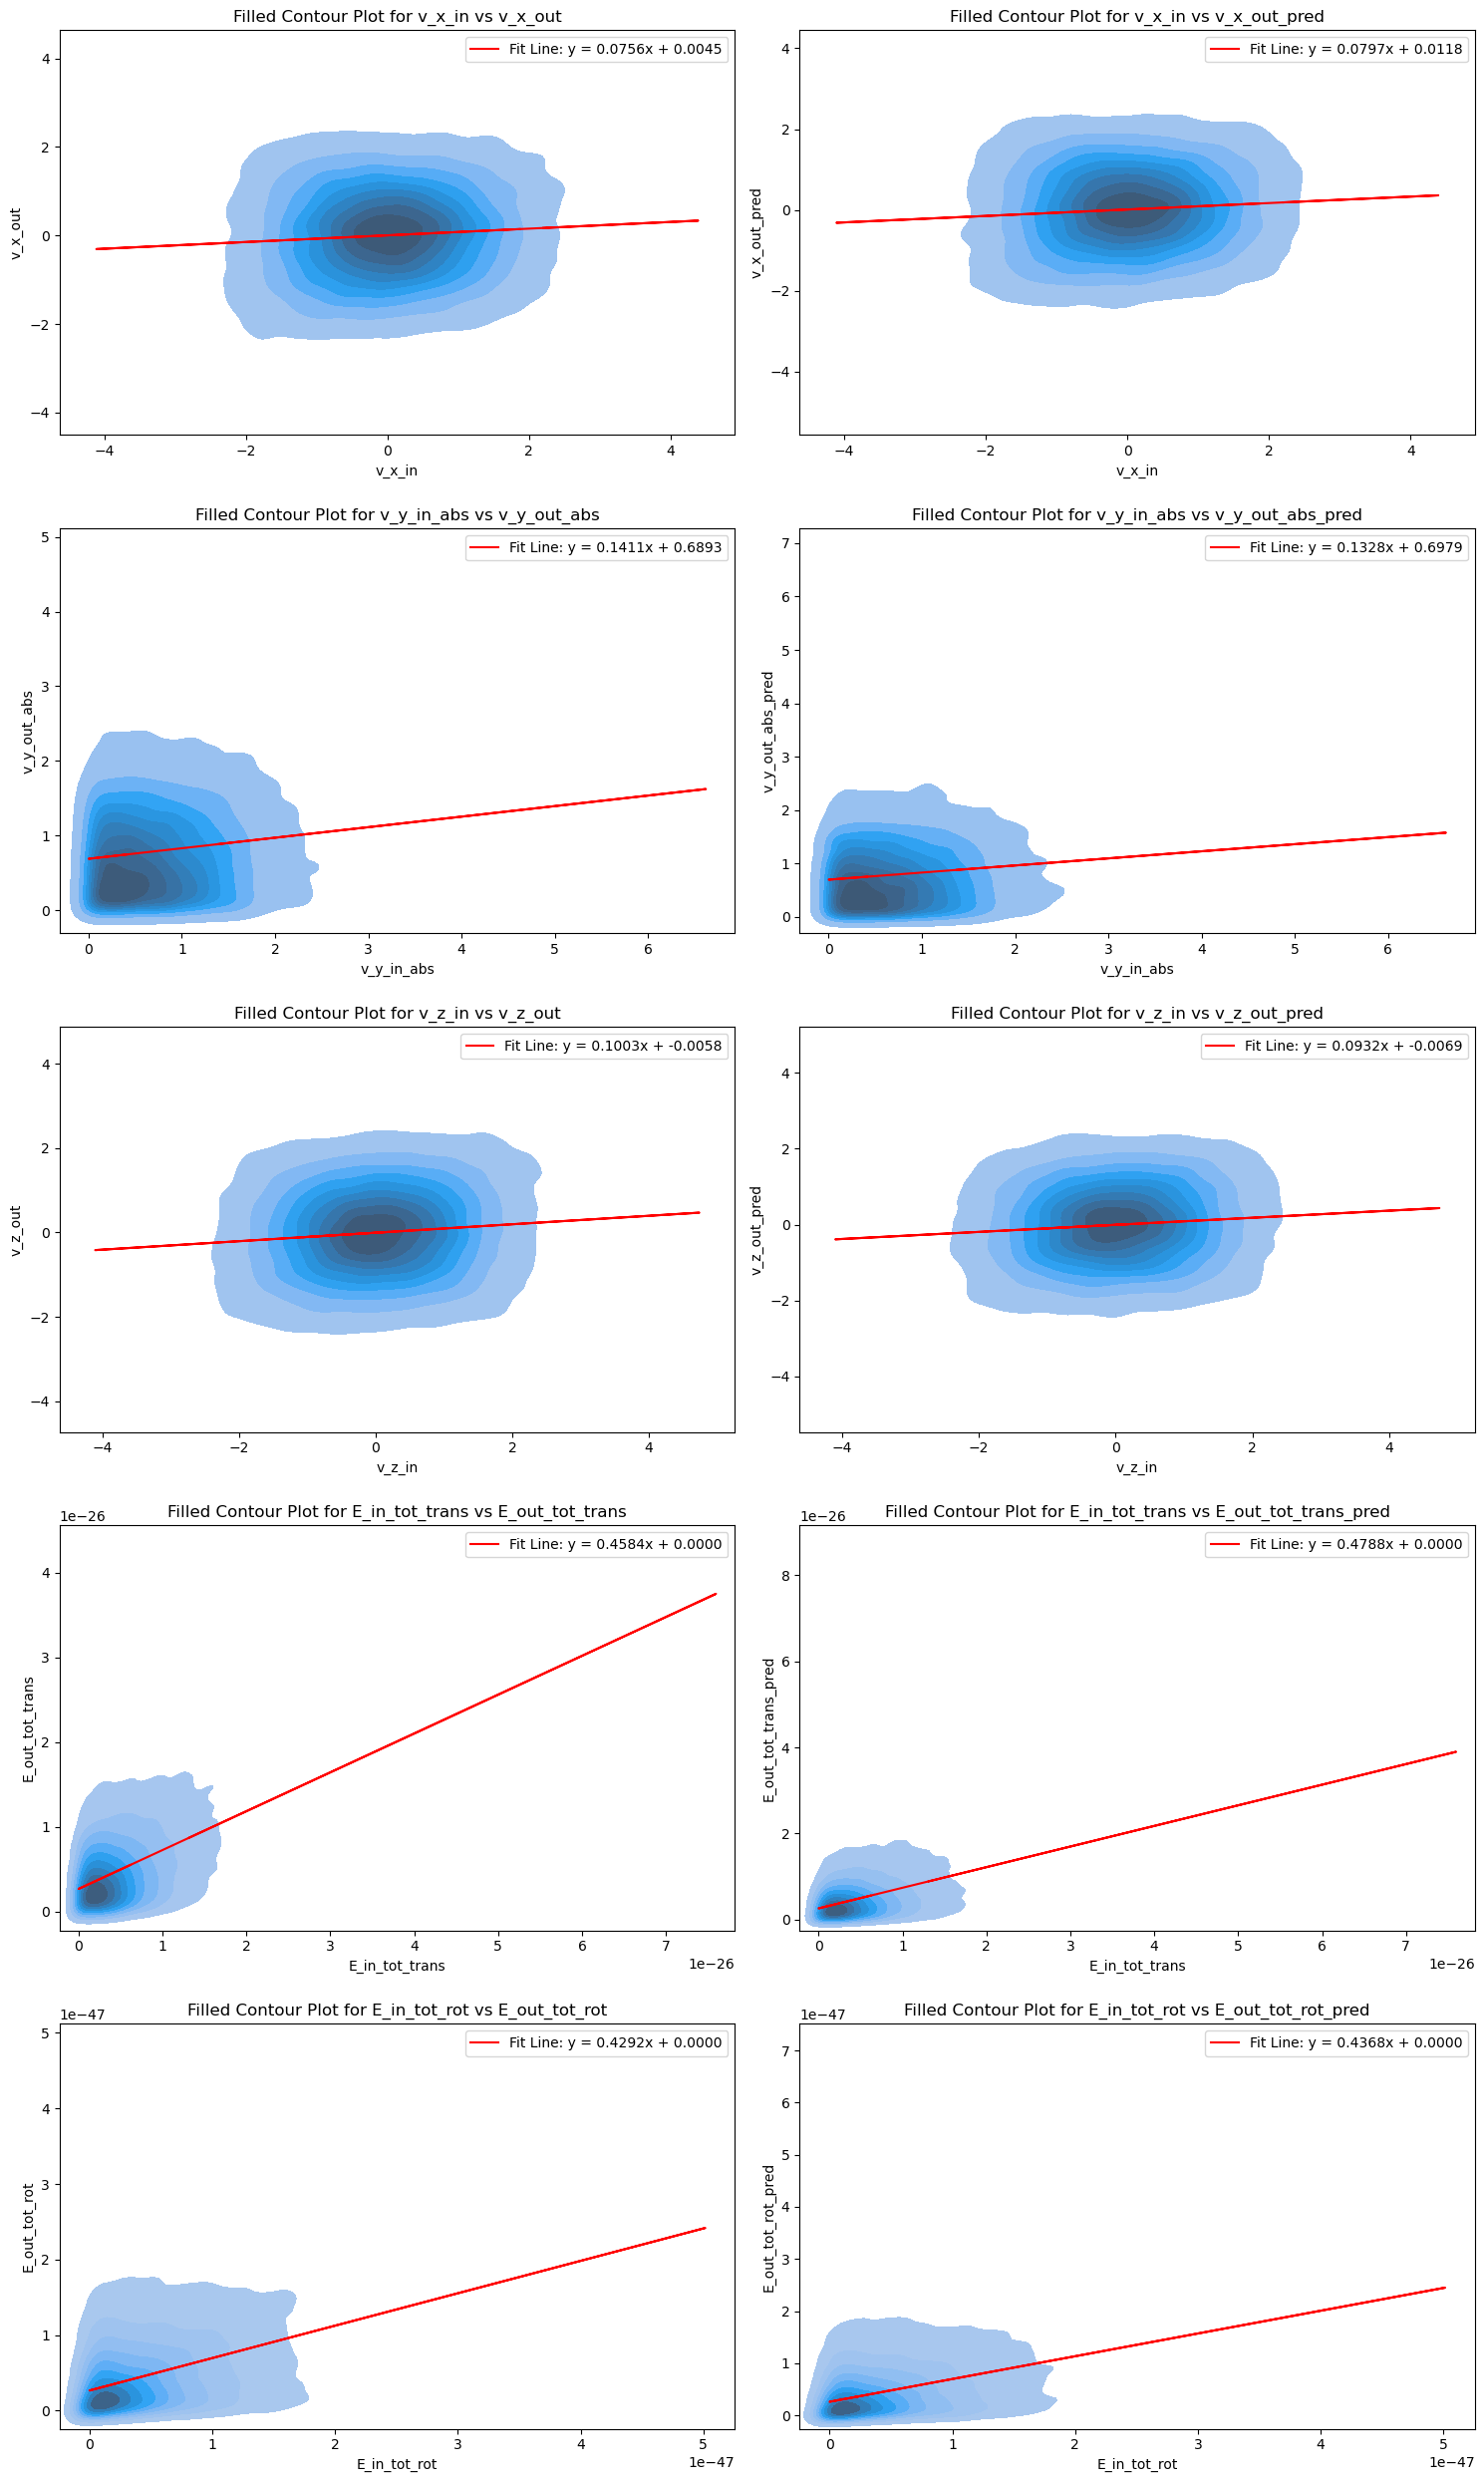

Slope, Intercept and AC for v_x_in vs v_x_out: Slope = 0.07557869087359884, Intercept = 0.004505654730686211, AC = 0.9244213091264012
Slope, Intercept and AC for v_x_in vs v_x_out_pred: Slope = 0.07974174932167567, Intercept = 0.011802121445963638, AC = 0.9202582506783243
Slope, Intercept and AC for v_y_in_abs vs v_y_out_abs: Slope = 0.1410837921725251, Intercept = 0.6893445383685256, AC = 0.8589162078274749
Slope, Intercept and AC for v_y_in_abs vs v_y_out_abs_pred: Slope = 0.13282466857347003, Intercept = 0.6979124191759937, AC = 0.86717533142653
Slope, Intercept and AC for v_z_in vs v_z_out: Slope = 0.10028640355357218, Intercept = -0.005754244222582344, AC = 0.8997135964464278
Slope, Intercept and AC for v_z_in vs v_z_out_pred: Slope = 0.09315726485343534, Intercept = -0.006867109970945797, AC = 0.9068427351465647
Slope, Intercept and AC for E_in_tot_trans vs E_out_tot_trans: Slope = 0.45838463166616383, Intercept = 2.695426972583229e-27, AC = 0.5416153683338362
Slope, Intercept an

In [22]:
calculate_AC_contor(df_results_norm, cols_pairs)